In [11]:

# Gerekli kütüphaneleri yükleyin
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from tqdm import tqdm

# Google Drive'ı bağla
drive.mount('/content/drive')

# Veri yolları
image_folder = '/content/drive/MyDrive/katman/Training/Images'
mask_folder = '/content/drive/MyDrive/katman/Training/Labels'
test_image_folder = '/content/drive/MyDrive/katman/Testing/Images'
test_mask_folder = '/content/drive/MyDrive/katman/Testing/Labels'

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])
mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])
test_image_files = sorted([os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith('.jpg')])
test_mask_files = sorted([os.path.join(test_mask_folder, f) for f in os.listdir(test_mask_folder) if f.endswith('.png')])

# Boyutları eşitle
min_length = min(len(image_files), len(mask_files))
image_files = image_files[:min_length]
mask_files = mask_files[:min_length]

test_min_length = min(len(test_image_files), len(test_mask_files))
test_image_files = test_image_files[:test_min_length]
test_mask_files = test_mask_files[:test_min_length]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print(f"Number of images: {len(image_files)}")
print(f"Number of masks: {len(mask_files)}")


Number of images: 28
Number of masks: 28


In [13]:
# Dataset tanımlaması
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, resize=(512, 512)):
        self.images_path = images_path
        self.masks_path = masks_path
        self.resize = resize
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.resize)  # Boyutunu 512x512 olarak değiştir
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.resize)  # Mask boyutunu da 512x512 olarak değiştir
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [14]:
# UNet modeli (kodda zaten doğru)
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [15]:
# UNet yapısını tanımlayın
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))

# UNet modelini oluşturmak için bir fonksiyon tanımlayın
def build_unet():
    return UNet()

# Dice ve BCE kayıp fonksiyonunu birleştiren özel kayıp fonksiyonu
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        smooth = 1e-6
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        bce_loss = self.bce_loss(inputs, targets)
        return dice_loss + bce_loss

# Dataset ve dataloader tanımlaması
train_dataset = DriveDataset(image_files, mask_files)
test_dataset = DriveDataset(test_image_files, test_mask_files)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Model, kayıp fonksiyonu ve optimizer tanımlama
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet().to(device)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [16]:
# Eğitim ve değerlendirme döngüleri
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [17]:
# Eğitim döngüsü
epochs = 50
best_loss = float("inf")
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, test_loader, loss_fn, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/katman/unet_best.pth')

# Modeli test et ve değerlendir
model.load_state_dict(torch.load('/content/drive/MyDrive/katman/unet_best.pth'))
model.eval()

Epoch 1/50, Train Loss: 1.4682, Val Loss: 1.5390
Epoch 2/50, Train Loss: 1.3411, Val Loss: 1.5347
Epoch 3/50, Train Loss: 1.2680, Val Loss: 1.5022
Epoch 4/50, Train Loss: 1.2081, Val Loss: 1.4431
Epoch 5/50, Train Loss: 1.1653, Val Loss: 1.3748
Epoch 6/50, Train Loss: 1.1279, Val Loss: 1.2783
Epoch 7/50, Train Loss: 1.1043, Val Loss: 1.1887
Epoch 8/50, Train Loss: 1.0865, Val Loss: 1.1213
Epoch 9/50, Train Loss: 1.0703, Val Loss: 1.0774
Epoch 10/50, Train Loss: 1.0563, Val Loss: 1.0428
Epoch 11/50, Train Loss: 1.0446, Val Loss: 1.0210
Epoch 12/50, Train Loss: 1.0332, Val Loss: 1.0153
Epoch 13/50, Train Loss: 1.0241, Val Loss: 1.0145
Epoch 14/50, Train Loss: 1.0131, Val Loss: 0.9941
Epoch 15/50, Train Loss: 1.0011, Val Loss: 0.9824
Epoch 16/50, Train Loss: 0.9898, Val Loss: 0.9772
Epoch 17/50, Train Loss: 0.9801, Val Loss: 0.9668
Epoch 18/50, Train Loss: 0.9693, Val Loss: 0.9573
Epoch 19/50, Train Loss: 0.9585, Val Loss: 0.9489
Epoch 20/50, Train Loss: 0.9510, Val Loss: 0.9370
Epoch 21/

<ipython-input-17-3d7ff7f4b365>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/katman/unet_best.pth'))


UNet(
  (encoder1): conv_block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): conv_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): conv_block(
    (conv1): C

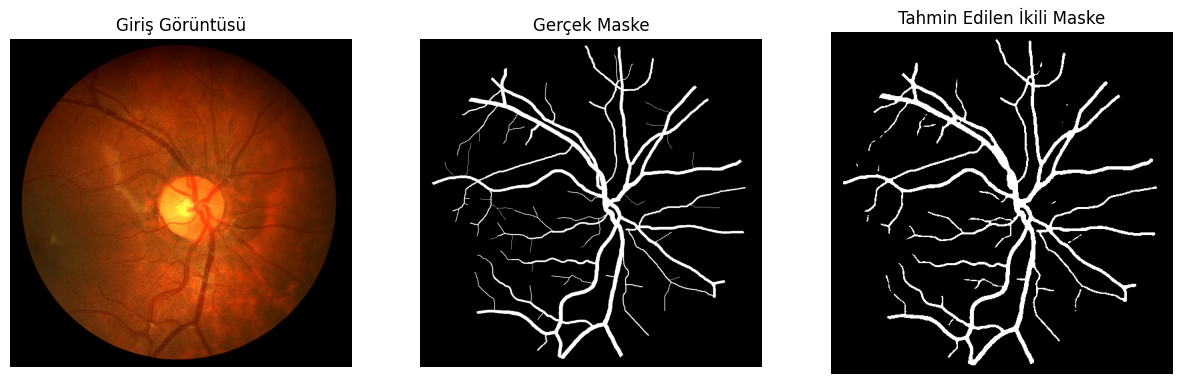

In [23]:
import matplotlib.pyplot as plt
# İkili Maske Eşikleme Fonksiyonu
def binarize_mask(predicted_mask, threshold=0.5):
    predicted_mask = predicted_mask.cpu().detach().numpy()  # Tensor'dan numpy dizisine dönüştür
    binary_mask = (predicted_mask[0, 0] > threshold).astype(np.uint8)  # İlk kanalı seç (2D olacak)

    # Morfolojik işlemler (Dilatasyon ve Erozyon)
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)

    return binary_mask

# Görselleştirme Fonksiyonu
def visualize_sample(image_path, mask_path, model, device):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predicted_mask = model(image_tensor)
        binary_mask = binarize_mask(predicted_mask, threshold=0.5)

    # Görselleri ve maskeleri görselleştirme
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Giriş Görüntüsü")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Gerçek Maske")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap="gray")  # binary_mask burada numpy dizisi
    plt.title("Tahmin Edilen İkili Maske")
    plt.axis("off")

    plt.show()

# Örnek Görselleştirme
sample_image_path = test_image_files[1]  # Test setindeki ilk görüntüyü seç
sample_mask_path = test_mask_files[1]    # Test setindeki ilk maskeyi seç
visualize_sample(sample_image_path, sample_mask_path, model, torch.device("cuda" if torch.cuda.is_available()else"cpu"))

IoU: 0.8639


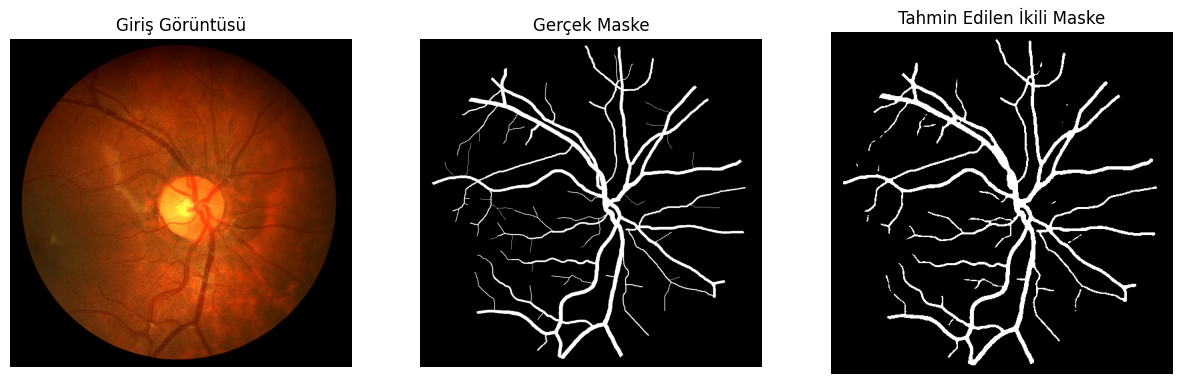

In [26]:
# IoU Hesaplama Fonksiyonu
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Görselleştirme Örneği ve IoU Hesaplama
def visualize_sample(image_path, mask_path, model, device):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    true_mask = cv2.resize(mask, (512, 512)) / 255.0

    model.eval()
    with torch.no_grad():
        predicted_mask = model(image_tensor)
        binary_mask = binarize_mask(predicted_mask, threshold=0.5)

    # IoU Hesaplama
    iou = calculate_iou(binary_mask, true_mask)
    print(f"IoU: {iou:.4f}")

    # Görselleştirme
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Giriş Görüntüsü")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Gerçek Maske")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Tahmin Edilen İkili Maske")
    plt.axis("off")

    plt.show()

# Örnek Görselleştirme ve IoU Hesaplama
sample_image_path = test_image_files[1]  # Test setindeki ilk görüntüyü seç
sample_mask_path = test_mask_files[1]    # Test setindeki ilk maskeyi seç
visualize_sample(sample_image_path, sample_mask_path, model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))
